# Data Exploration

## Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [9]:
%matplotlib inline

## Indexing the files

In [12]:
directory = "data/train/"
d = os.listdir(directory)
filenames = []
for f in d:
    if ".png" not in f:
        continue
    filenames.append(f)

## Displaying a Sample

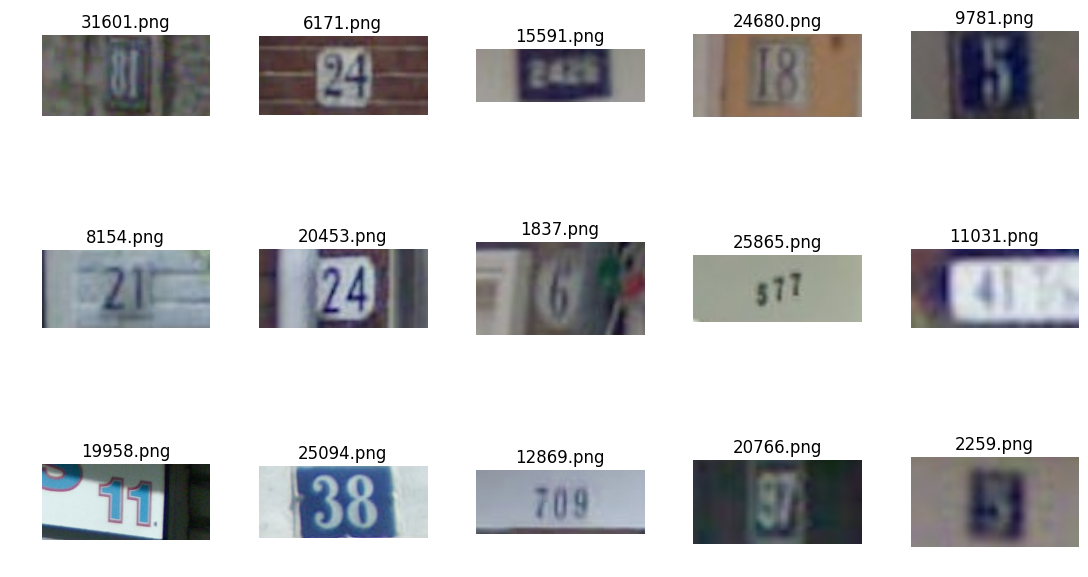

In [18]:
fig = plt.figure(figsize=(11, 7))
i = 1
rows = 3
columns = 5
for c in np.random.choice(len(filenames), rows * columns):
    img = mpimg.imread(directory + filenames[i])
    fig.add_subplot(rows, columns, i)
    i += 1
    plt.title(filenames[i])
    plt.axis("off")
    plt.imshow(img)
plt.tight_layout()
plt.show()

# Exploratory Visualization